IFC TO GRAPH

Processed 100 entities. Limiting for testing.
Vertices:
Node ID: 5795, Data: {'id': 5795, 'type': 'IfcUnitAssignment', 'Units': (#19=IfcSIUnit(*,.LENGTHUNIT.,.MILLI.,.METRE.), #49=IfcSIUnit(*,.AREAUNIT.,$,.SQUARE_METRE.), #154=IfcDerivedUnit((#149,#151,#153),.THERMALTRANSMITTANCEUNIT.,$), #5524=IfcConversionBasedUnit(#5522,.PLANEANGLEUNIT.,'DEGREE',#5523))}
Node ID: 19, Data: {'id': 19, 'type': 'IfcSIUnit', 'Dimensions': None, 'UnitType': 'LENGTHUNIT', 'Prefix': 'MILLI', 'Name': 'METRE'}
Node ID: 49, Data: {'id': 49, 'type': 'IfcSIUnit', 'Dimensions': None, 'UnitType': 'AREAUNIT', 'Prefix': None, 'Name': 'SQUARE_METRE'}
Node ID: 154, Data: {'id': 154, 'type': 'IfcDerivedUnit', 'Elements': (#149=IfcDerivedUnitElement(#148,1), #151=IfcDerivedUnitElement(#150,-1), #153=IfcDerivedUnitElement(#152,-3)), 'UnitType': 'THERMALTRANSMITTANCEUNIT', 'UserDefinedType': None}
Node ID: 5524, Data: {'id': 5524, 'type': 'IfcConversionBasedUnit', 'Dimensions': #5522=IfcDimensionalExponents(0,0,0,0,0,0,0

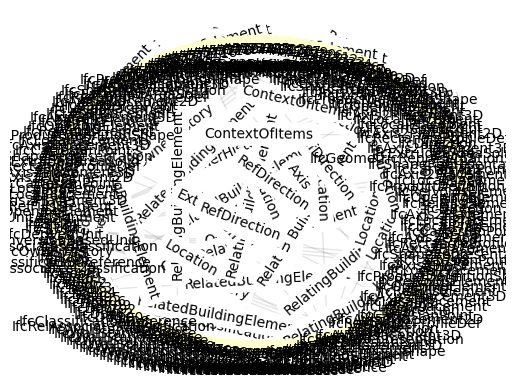

In [3]:
 import ifcopenshell
import networkx as nx
import matplotlib.pyplot as plt
import math

class fuzzy_dict(object):
    def __init__(self, d, eps=1e-5, guid=None):
        self.d = d
        self.eps = eps
        self.guid = guid
        
        mod = - int(round(math.log10(eps * 100)))
        def c(v):
            if isinstance(v, float):
                return round(v, mod)
            elif isinstance(v, dict):
                return tuple(sorted((k,c(v)) for k, v in v.items()))
            elif isinstance(v, (tuple, list)):
                return type(v)(map(c, v))
            else:
                return v
                
        self.h = hash(c(self.d))
        
    def __hash__(self):
        return self.h
         
    def __eq__(self, other):
    
        def eq(v1, v2):
            if type(v1) != type(v2):
                return False
            if isinstance(v1, float):
                if abs(v1 - v2) > self.eps: return False
            elif isinstance(v1, dict):
                if not (fuzzy_dict(v1, eps=self.eps) == fuzzy_dict(v2, eps=self.eps)): return False
            elif isinstance(v1, (tuple, list)):
                if len(v1) != len(v2): return False
                for a, b in zip(v1, v2):
                    if not eq(a, b): return False
            else:
                if v1 != v2: return False
            return True
        
        if set(self.d.keys()) != set(other.d.keys()): return
        
        for v1, v2 in ((self.d[k], other.d[k]) for k in self.d):
            if not eq(v1, v2): return False
            
        return True


def add_to_graph(existing, new, edge_label, G):
    G.add_node(new.id(), **new.get_info())
    G.add_edge(existing.id(), new.id(), weight=7, edge_label=edge_label)

def is_entity_instance(val):
    return val.id() != 0 and isinstance(val, ifcopenshell.entity_instance)

def remove_id_key(d):
    new_d = {}
    for k, v in d.items():
        if k != 'id':
            new_d[k] = v

    return new_d
    
def create_graph(ifc_file, limit=None, element_types=None):
    G = nx.DiGraph()
    for idx, entity in enumerate(ifc_file):
        if limit and idx >= limit:
            print(f"Processed {limit} entities. Limiting for testing.")
            break

        info = entity.get_info()
        G.add_node(info['id'], **info)
        
        for attr_name, attr_val in info.items():
            if isinstance(attr_val, ifcopenshell.entity_instance):
                if attr_val.id() != 0:
                    add_to_graph(entity, attr_val, attr_name, G)
            elif isinstance(attr_val, tuple):
                for element in attr_val:
                    if isinstance(element, ifcopenshell.entity_instance):
                        if element.id() != 0:
                            add_to_graph(entity, element, attr_name, G)

        if entity.is_a("IfcRelAggregates") or entity.is_a("IfcRelContainedInSpatialStructure"):
            related_elements = (entity.RelatedObjects if entity.is_a("IfcRelAggregates")
                                else entity.RelatedElements)
            for related in related_elements:
                G.add_node(related.id(), **related.get_info())
                G.add_edge(entity.id(), related.id(), edge_label="Related")

    return G

def draw_graph(G, layout='shell'):
    labels = {}
    for n in G.nodes.values():
        labels[n['id']] = "#" + str(n['id'])+"\n" + n['type']
    cm = [] 
    for n in G.nodes.values():
        cm.append((1,1,0.8))
    
    edges_labels = {}
    for e in G.edges().data():
        edges_labels[(e[0],e[1])] = e[2]["edge_label"]

    if layout == 'shell':
        pos = nx.shell_layout(G)
    elif layout == 'random':
        pos = nx.random_layout(G)
    else:
        pos = nx.spring_layout(G, k=0.6, iterations=3)

    nn = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=cm, node_size=80, node_shape='o')
    ne = nx.draw_networkx_edges(G, pos, edgelist=G.edges, arrows=True, alpha=0.1)
    edgelabels  = nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_size=10)
    labels  = nx.draw_networkx_labels(G, pos, labels=labels, verticalalignment='top', font_size=10)

    plt.axis("off")
    plt.show()
    

if __name__ == "__main__":

    ifc_file_path = r"C:\Users\papad\Desktop\floorplanexamplpleasee.ifc"

    try:
        ifc_file = ifcopenshell.open(ifc_file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error opening IFC file: {e}")

    # Limit processing to 100 entities for testing
    G = create_graph(ifc_file, limit=100)   

    # Print vertices
    print("Vertices:")
    for node_id, data in G.nodes(data=True):
        print(f"Node ID: {node_id}, Data: {data}")

    # Print all element types
    print("\nAll Element Types:")
    all_types = set()
    for entity in ifc_file:
        all_types.add(entity.is_a())
    for element_type in sorted(all_types):
        print(element_type)

    # Check for IfcWall elements
    wall_count = 0
    print("\nElements with IfcPredefinedType = STANDARD:")
    for node_id, data in G.nodes(data=True):
        if data.get('IfcPredefinedType') == 'STANDARD':
            print(f"Node ID: {node_id}, Data: {data}")
            if data.get('type') == 'IfcWall':
                wall_count += 1

    if wall_count > 0:
        print(f"\nNumber of IfcWall elements with IfcPredefinedType = STANDARD: {wall_count}")
    else:
        print("\nNo IfcWall elements with IfcPredefinedType = STANDARD found in the IFC file.")

    # Print edges
    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"Edge from {u} to {v}, Data: {data}")

    # Draw the graph with a faster layout
    draw_graph(G, layout='shell')

Vertices:
Node ID: 2321, Data: {'id': 2321, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVlI', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3049=IfcLocalPlacement(#3039,#3048)', 'Representation': '#2317=IfcProductDefinitionShape($,$,(#2316))', 'Tag': '1664109', 'OverallHeight': 2100.0, 'OverallWidth': 850.0}
Node ID: 2286, Data: {'id': 2286, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVkU', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3029=IfcLocalPlacement(#3019,#3028)', 'Representation': '#2282=IfcProductDefinitionShape($,$,(#2281))', 'Tag': '1664033', 'OverallHeight': 2100.0, 'OverallWidth

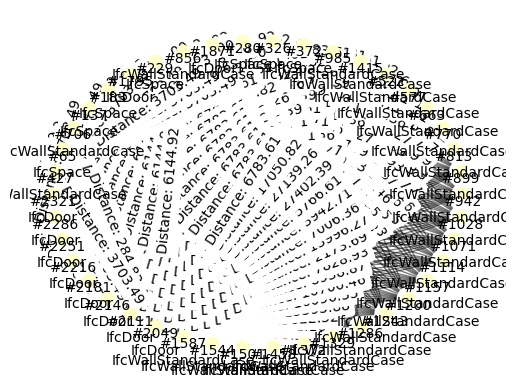

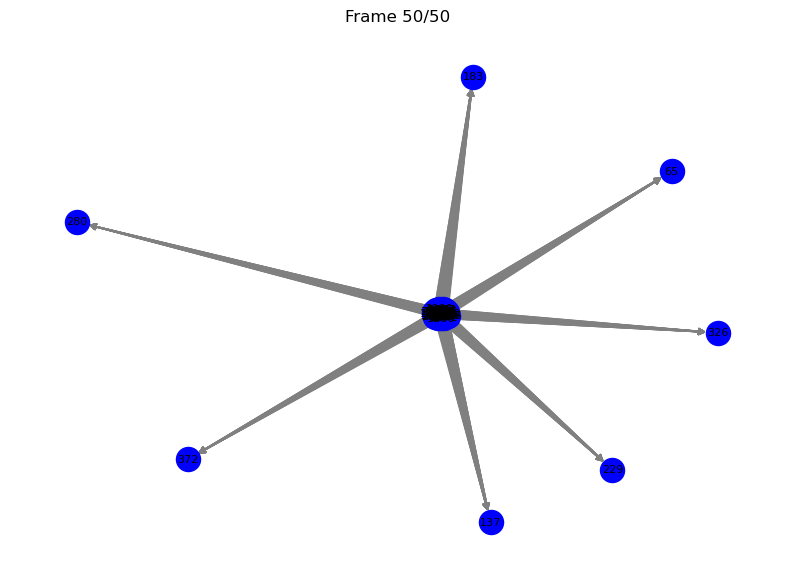

In [43]:
import ifcopenshell
import networkx as nx
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation

def add_to_graph(existing, new, edge_label, G):
    G.add_node(new.id(), **new.get_info())
    G.add_edge(existing.id(), new.id(), weight=7, edge_label=edge_label)

def is_entity_instance(val):
    return val.id() != 0 and isinstance(val, ifcopenshell.entity_instance)

def get_global_coordinates(entity):
    placement = getattr(entity, 'ObjectPlacement', None)
    if placement and placement.is_a('IfcLocalPlacement'):
        relative_placement = placement.RelativePlacement
        if relative_placement and relative_placement.is_a('IfcAxis2Placement3D'):
            location = relative_placement.Location
            if location and hasattr(location, 'Coordinates'):
                return tuple(location.Coordinates)
    return (0.0, 0.0, 0.0)

def calculate_distance(coord1, coord2):
    return math.sqrt(sum((c2 - c1) ** 2 for c1, c2 in zip(coord1, coord2)))

def preprocess_graph_attributes(G):
    for node, data in G.nodes(data=True):
        # Convert non-serializable attributes to strings or remove them
        for key, value in list(data.items()):
            if not isinstance(value, (str, int, float, bool, type(None))):
                data[key] = str(value)

    for u, v, data in G.edges(data=True):
        # Convert non-serializable edge attributes
        for key, value in list(data.items()):
            if not isinstance(value, (str, int, float, bool, type(None))):
                data[key] = str(value)

def create_graph(ifc_file):
    G = nx.DiGraph()
    element_coords = {}

    wall_ids = []
    door_ids = []
    room_ids = []

    for entity in ifc_file:
        info = entity.get_info()

        # Filter walls, doors, and rooms
        if entity.is_a("IfcWallStandardCase") or entity.is_a("IfcWall"):
            wall_ids.append(entity.id())
            G.add_node(entity.id(), **entity.get_info())
            element_coords[entity.id()] = get_global_coordinates(entity)

        elif entity.is_a("IfcDoor"):
            door_ids.append(entity.id())
            G.add_node(entity.id(), **entity.get_info())
            element_coords[entity.id()] = get_global_coordinates(entity)

        elif entity.is_a("IfcSpace"):
            room_ids.append(entity.id())
            room_name = getattr(entity, 'Name', f"Room_{entity.id()}")  # Use the architect-specified name
            G.add_node(entity.id(), **entity.get_info(), label=room_name)  # Add the room name as a label
            element_coords[entity.id()] = get_global_coordinates(entity)

    # Add edges only between walls, doors, and rooms with distance calculation
    for wall in wall_ids:
        for door in door_ids:
            coord1 = element_coords.get(wall, (0.0, 0.0, 0.0))
            coord2 = element_coords.get(door, (0.0, 0.0, 0.0))
            distance = calculate_distance(coord1, coord2)
            G.add_edge(wall, door, edge_label=f"Distance: {distance:.2f}")

        for room in room_ids:
            coord1 = element_coords.get(wall, (0.0, 0.0, 0.0))
            coord2 = element_coords.get(room, (0.0, 0.0, 0.0))
            distance = calculate_distance(coord1, coord2)
            G.add_edge(wall, room, edge_label=f"Distance: {distance:.2f}")

    for door in door_ids:
        for room in room_ids:
            coord1 = element_coords.get(door, (0.0, 0.0, 0.0))
            coord2 = element_coords.get(room, (0.0, 0.0, 0.0))
            distance = calculate_distance(coord1, coord2)
            G.add_edge(door, room, edge_label=f"Distance: {distance:.2f}")

    return G

def draw_graph(G, layout='shell'):
    labels = {}
    for n in G.nodes.values():
        labels[n['id']] = "#" + str(n['id']) + "\n" + n['type']
    cm = []
    for n in G.nodes.values():
        cm.append((1, 1, 0.8))

    edges_labels = {}
    for e in G.edges().data():
        edges_labels[(e[0], e[1])] = e[2]["edge_label"]

    if layout == 'shell':
        pos = nx.shell_layout(G)
    elif layout == 'random':
        pos = nx.random_layout(G)
    else:
        pos = nx.spring_layout(G, k=0.6, iterations=3)

    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=cm, node_size=80, node_shape='o')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, arrows=True, alpha=0.5)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_size=10)
    nx.draw_networkx_labels(G, pos, labels=labels, verticalalignment='top', font_size=10)

    plt.axis("off")
    plt.show()

def save_graph_as_gif(G, output_path, frames=50):
    fig, ax = plt.subplots(figsize=(10, 7))

    pos = nx.spring_layout(G, seed=42)

    def update(frame):
        ax.clear()
        updated_pos = {node: (coord[0] + 0.01 * frame, coord[1]) for node, coord in pos.items()}
        nx.draw(G, updated_pos, with_labels=True, ax=ax, node_size=300, font_size=8, edge_color="gray", node_color="blue")
        ax.set_title(f"Frame {frame + 1}/{frames}")

    ani = FuncAnimation(fig, update, frames=frames, interval=200, repeat=False)
    ani.save(output_path, writer="pillow")

if __name__ == "__main__":

    ifc_file_path = r"C:\Users\papad\Desktop\floorplanexampleroomswithnames.ifc"

    try:
        ifc_file = ifcopenshell.open(ifc_file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error opening IFC file: {e}")

    # Create graph for walls, doors, and rooms
    G = create_graph(ifc_file)

    # Preprocess the graph attributes to ensure compatibility
    preprocess_graph_attributes(G)

    # Print vertices
    print("Vertices:")
    for node_id, data in G.nodes(data=True):
        print(f"Node ID: {node_id}, Data: {data}")

    # Print edges
    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"Edge from {u} to {v}, Data: {data}")

    # Draw the graph
    draw_graph(G, layout='shell')

